<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/GokuMohandas/MadeWithML" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

# OpenAI

In our [Made With ML course](https://madewithml.com/) we will be finetuning an LLM by actually changing the weights of it's last N layers. But before we try that, let's see how far we can get with OpenAI's GPT models with zero and few-short learning.

### Set up

In [1]:
!pip install openai tqdm -q

In [2]:
import openai
openai.api_key = "YOUR_API_KEY"  # delete this line after running it

### Load data

In [3]:
import pandas as pd

In [4]:
# Load into dataframe
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/madewithml/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [5]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/madewithml/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

### Split data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [8]:
# Unique labels
tags = train_df.tag.unique().tolist()
tags

['mlops', 'natural-language-processing', 'computer-vision', 'other']

### Set up

We'll define a few setup functions to make the OpenAI request and to store our predictions. While we could perform batch prediction by loading samples until the context length is reached, we'll just perform one at a time since it's not too many data points and we can have fully deterministic behavior (if you insert new data, etc.). We'll also added some reliability in case we overload the endpoints with too many request at once.

In [9]:
import time
from tqdm import tqdm

In [10]:
def get_tag(model, system_content, user_content):
    try:
        # Get response from OpenAI
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
            ],
        )
        predicted_tag = response.to_dict()["choices"][0].to_dict()["message"]["content"]
        return predicted_tag
    
    except (openai.error.ServiceUnavailableError, openai.error.APIError) as e:
        return None

In [28]:
def get_predictions(inputs, model, context):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)
        
        # Get prediction
        predicted_tag = get_tag(model=model, system_content=context, user_content=user_content)
        
        # If error, try again after pause (repeatedly until success)
        while predicted_tag is None: 
            time.sleep(30)  # could also do exponential backoff
            predicted_tag = get_tag(model=model, system_content=context, user_content=user_content)
                    
        # Add to list of predictions
        y_pred.append(predicted_tag)
                    
    return y_pred

In [12]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)
    
    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

In [23]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
            y_pred[i] = item[1:-1]
    return y_pred

In [14]:
def show_results(y_true, y_pred, tags):
    print (f"Before: {dict(Counter(y_pred))}")
    cleaned_pred = clean_predictions(y_pred=y_pred, tags=tags)
    print (f"After: {dict(Counter(y_pred))}")
    plot_tag_dist(y_true=y_true, y_pred=cleaned_pred)

In [15]:
test_samples = test_df[["title", "description"]].to_dict(orient="records")
y_test = test_df.tag.to_list()
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

### Zero-shot learning

In [16]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support

In [17]:
zero_shot_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description. 
    You must choose between one of the following labels for each input: {tags}. 
    Only respond with the label name and nothing else.
    """

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [01:50<00:00,  1.73it/s]
/Users/goku/Documents/mlops-course/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.7780264219632569, 'recall': 0.7853403141361257, 'f1': 0.7662484230576545}
Before: {'other': 8, 'natural-language-processing': 78, 'computer-vision': 72, 'mlops': 31, 'time-series-forecasting': 2}
After: {'other': 10, 'natural-language-processing': 78, 'computer-vision': 72, 'mlops': 31}


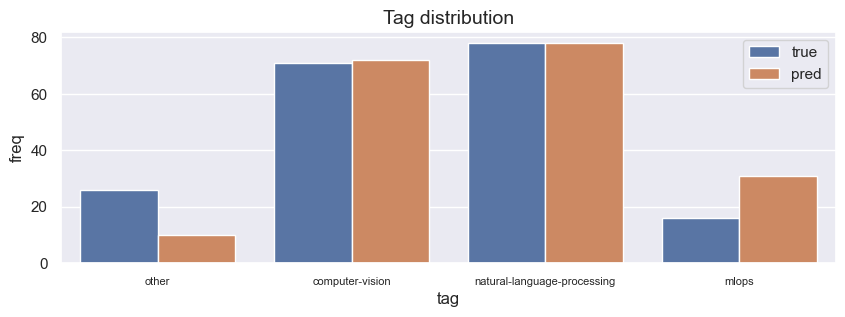

In [18]:
# Zero-shot with GPT 3.5
method = "zero_shot"
model = "gpt-3.5-turbo-0613"
y_pred[method][model] = get_predictions(inputs=test_samples, model=model, context=zero_shot_context)
metrics = precision_recall_fscore_support(y_test, y_pred[method][model], average="weighted")
performance[method][model] =  {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (performance[method][model])
show_results(y_true=y_test, y_pred=y_pred[method][model], tags=tags)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [02:38<00:00,  1.20it/s]

{'precision': 0.8910994764397905, 'recall': 0.3403141361256545, 'f1': 0.4513558480308185}
Before: {"'other'": 24, "'computer-vision'": 64, 'natural-language-processing': 50, 'computer-vision': 9, "'natural-language-processing'": 25, 'mlops': 5, "'mlops'": 9, 'other': 5}
After: {'other': 29, 'computer-vision': 73, 'natural-language-processing': 75, 'mlops': 14}



/Users/goku/Documents/mlops-course/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


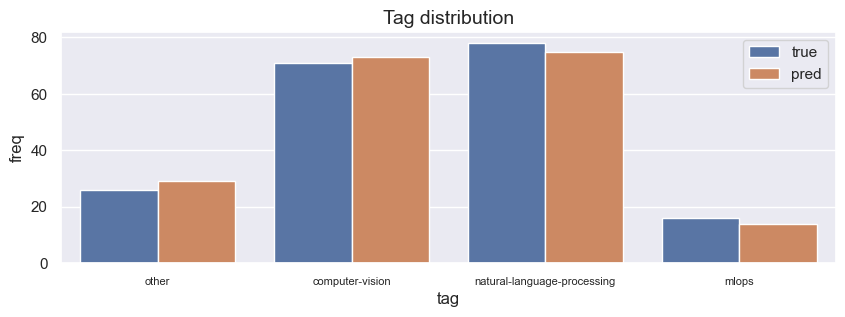

In [24]:
# Zero-shot with GPT 4
method = "zero_shot"
model = "gpt-4-0613"
y_pred[method][model] = get_predictions(inputs=test_samples, model=model, context=zero_shot_context)
metrics = precision_recall_fscore_support(y_test, y_pred[method][model], average="weighted")
performance[method][model] =  {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (performance[method][model])
show_results(y_true=y_test, y_pred=y_pred[method][model], tags=tags)

### Few-shot learning

In [25]:
# Create additional context with few samples from each class
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:2].to_dict(orient="records")
    additional_context.extend(samples)

In [26]:
# Add additional context
few_shot_context = zero_shot_context + f"""Here are some examples with the correct labels: {additional_context}"""

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [06:19<00:00,  1.98s/it]

{'precision': 0.8080789193354638, 'recall': 0.7958115183246073, 'f1': 0.7935669583781015}
Before: {'natural-language-processing': 77, 'computer-vision': 66, 'other': 16, 'mlops': 30, 'time-series-forecasting': 1, 'graph': 1}
After: {'natural-language-processing': 77, 'computer-vision': 66, 'other': 18, 'mlops': 30}



/Users/goku/Documents/mlops-course/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


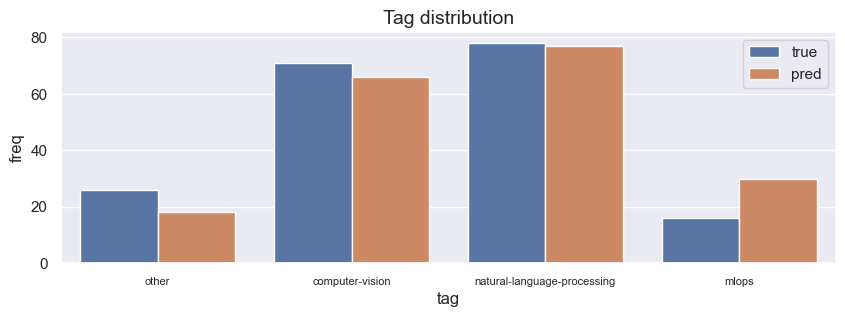

In [29]:
# Few-shot with GPT 3.5
method = "few_shot"
model = "gpt-3.5-turbo-0613"
y_pred["few_shot"][model] = get_predictions(inputs=test_samples, model=model, context=few_shot_context)
metrics = precision_recall_fscore_support(y_test, y_pred["few_shot"][model], average="weighted")
performance[method][model] =  {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (performance[method][model])
show_results(y_true=y_test, y_pred=y_pred[method][model], tags=tags)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [01:54<00:00,  1.66it/s]

{'precision': 0.9697498545666086, 'recall': 0.3717277486910995, 'f1': 0.5209768182997263}
Before: {"'other'": 25, "'computer-vision'": 47, "'natural-language-processing'": 31, 'computer-vision': 15, 'natural-language-processing': 42, 'other': 9, 'mlops': 7, "'mlops'": 15}
After: {'other': 34, 'computer-vision': 62, 'natural-language-processing': 73, 'mlops': 22}



/Users/goku/Documents/mlops-course/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


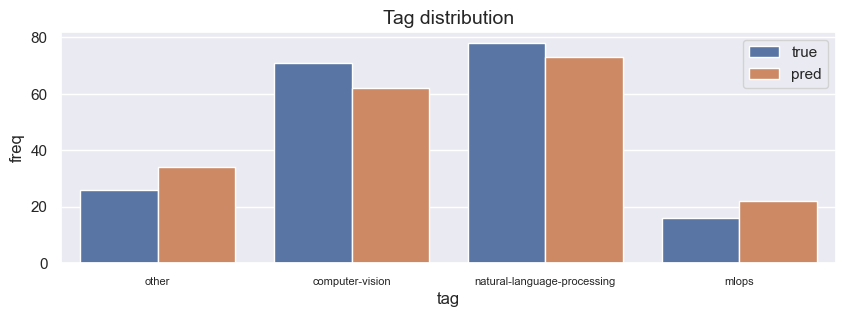

In [30]:
# Few-shot with GPT 4
method = "few_shot"
model = "gpt-4-0613"
y_pred[method][model] = get_predictions(inputs=test_samples, model=model, context=few_shot_context)
metrics = precision_recall_fscore_support(y_test, y_pred[method][model], average="weighted")
performance[method][model] =  {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (performance[method][model])
show_results(y_true=y_test, y_pred=y_pred[method][model], tags=tags)

### Results

In [33]:
print(json.dumps(performance, indent=2))

{
  "zero_shot": {
    "gpt-3.5-turbo-0613": {
      "precision": 0.7780264219632569,
      "recall": 0.7853403141361257,
      "f1": 0.7662484230576545
    },
    "gpt-4-0613": {
      "precision": 0.8910994764397905,
      "recall": 0.3403141361256545,
      "f1": 0.4513558480308185
    }
  },
  "few_shot": {
    "gpt-3.5-turbo-0613": {
      "precision": 0.8080789193354638,
      "recall": 0.7958115183246073,
      "f1": 0.7935669583781015
    },
    "gpt-4-0613": {
      "precision": 0.9697498545666086,
      "recall": 0.3717277486910995,
      "f1": 0.5209768182997263
    }
  }
}


As we can see, few shot learning performs better than it's respective zero shot counter part. GPT 4 has had considerable improvements in reducing hallucinations but for our supervised task this comes at an expense of high precision but lower recall and f1 scores. When GPT 4 is not confident, it would rather predict `other`.

Our best model is GPT 3.5 with few shot learning at an f1 score of ~80%. We will see in the [Made With ML course](https://madewithml.com/) how fine-tuning an LLM with a proper training dataset to change the actual weights of the last N layers (as opposed to the hard prompt tuning here) will yield a significantly more performant model (**>90%** across *all* metrics without any hyperparameter tuning).

However, the best system might actually be a combination of using these few-shot hard prompt LLMs alongside fine-tuned LLMs. For example, our fine-tuned LLMs in the course will perform well when the test data is similar to the training data (similar distributions of vocabulary, etc.) but may not perform well on out of distribution. Whereas, these hard prompted LLMs, by themselves or augmented with additional context (ex. arXiv plugins in our case), could be used when our primary fine-tuned model is not so confident.

### Extensions

And of course, there are plenty more things to try:

    - more few-shot examples by using models that will accept longer contexts
    - experiment with different API functionality (ex. the functional calling API for standardized outputs, etc.)
    
But this implementation so far gives us an estimate of how well these large language models can perform with no/little additonal context. However, in the course we'll be finetuning an LLM by using training data to change the underying weights of the last N layers of our models. This yields greater than 10% increase across our metrics with faster inference speeds as well!